<a href="https://colab.research.google.com/github/FishSnacks6/FishSnacks6/blob/main/Atlas_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root = "data", train = True, transform = ToTensor(), download = True)
test_data = datasets.MNIST(root = "data", train = False, transform = ToTensor(), download = True)

from torch.utils.data import DataLoader

loaders = {
    "train" : DataLoader(train_data, batch_size = 100, shuffle = True, num_workers = 1),
    "test" : DataLoader(test_data, batch_size = 100, shuffle = True, num_workers = 1)
}

import torch.nn as nn
import torch.nn.functional as nF
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = nF.relu(nF.max_pool2d(self.conv1(x), 2))
    x = nF.relu(nF.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

    x = x.view(-1, 320)

    x = nF.relu(self.fc1(x))
    x = nF.dropout(x, training = self.training)
    x = self.fc2(x)

    return nF.softmax(x, dim = 1)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders["train"]):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print(f"Train epoch : {epoch} [{batch_idx*len(data)}/{len(loaders["train"].dataset)}({100. * batch_idx / len(loaders['train']): .0f}%)]\t{loss.item(): .6f}")

def test():
  model.eval()

  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loaders["test"]:
      data, target = data.to(device), target.to(device)
      output = model(data)

      test_loss += loss_fn(output, target).item()
      prediction = output.argmax(dim = 1, keepdim = True)
      correct += prediction.eq(target.view_as(prediction)).sum().item()

  test_loss /= len(loaders["test"].dataset)
  print(f"\nTest set : Average loss : {test_loss : .4f}, Accuracy : {correct}/{len(loaders["test"].dataset)} ({100. * correct/ len(loaders["test"].dataset) : .0f}%\n)")

for epoch in range(1, 11):
  train(epoch)
  test()


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 425kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.91MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.94MB/s]


Train epoch : 1 [0/60000( 0%)]	 2.302640
Train epoch : 1 [2000/60000( 3%)]	 2.288961
Train epoch : 1 [4000/60000( 7%)]	 2.153498
Train epoch : 1 [6000/60000( 10%)]	 2.005204
Train epoch : 1 [8000/60000( 13%)]	 1.946867
Train epoch : 1 [10000/60000( 17%)]	 1.892312
Train epoch : 1 [12000/60000( 20%)]	 1.866784
Train epoch : 1 [14000/60000( 23%)]	 1.757355
Train epoch : 1 [16000/60000( 27%)]	 1.828720
Train epoch : 1 [18000/60000( 30%)]	 1.787444
Train epoch : 1 [20000/60000( 33%)]	 1.729186
Train epoch : 1 [22000/60000( 37%)]	 1.720752
Train epoch : 1 [24000/60000( 40%)]	 1.743834
Train epoch : 1 [26000/60000( 43%)]	 1.658393
Train epoch : 1 [28000/60000( 47%)]	 1.741932
Train epoch : 1 [30000/60000( 50%)]	 1.683105
Train epoch : 1 [32000/60000( 53%)]	 1.721299
Train epoch : 1 [34000/60000( 57%)]	 1.699957
Train epoch : 1 [36000/60000( 60%)]	 1.688412
Train epoch : 1 [38000/60000( 63%)]	 1.667417
Train epoch : 1 [40000/60000( 67%)]	 1.671892
Train epoch : 1 [42000/60000( 70%)]	 1.640414

Prediction : 0


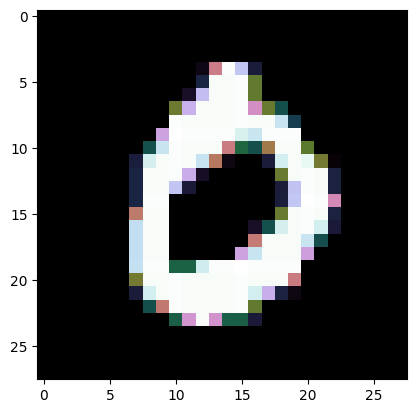

In [66]:
import matplotlib.pyplot as plt
import random

model.eval()
data, target = test_data[random.randint(0, 100)]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim = 1, keepdim = True).item()
print(f"Prediction : {prediction}")

image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap = "cubehelix")
plt.show()